In [24]:
%load_ext autoreload
import pandas as pd

import glob
import os
import numpy as np 
from numpy import genfromtxt
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from tqdm import tqdm_notebook
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import XKCD_COLORS, BASE_COLORS
from joblib import Parallel, delayed, pool

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor, KNeighborsRegressor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE

from scipy.spatial.distance import braycurtis
from utils import js, calculate_Q_mae

from umap import UMAP

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# WAYS TO DENOISE:
 - remove points with high MAE iteratively (seems wrong)
 - remove outliers iteratively (wrong, does not really work)
 

In [133]:
data_orig = {}
data_pca = {}
for dataset in ['ptb', 'HMP']:
    for tax_level in ['o', 'f', 'g']:

        dataframe_out = pd.read_csv(f'{dataset}/pivot_{tax_level}_normalized.csv', skipinitialspace=True, sep=';', engine='python')
        dataframe_out = dataframe_out.drop('Unnamed: 0', axis = 1).values
        
        name = '_'.join([dataset, tax_level])
        data_orig[name] = dataframe_out
#         data_pca[name] = pd.read_csv(f'./separate_datasets_proj/{dataset}_proj_{tax_level}.csv', skipinitialspace=True, sep=';', engine='python', header=None).values

# Compute metrics: JS

In [52]:
# for data_name, data in data_orig.items():
#     n = data.shape[0]
#     triu_indx = np.stack(np.triu_indices(n, k=1)).transpose(1,0)
#     result = Parallel(n_jobs=-1)(delayed(js)(data[i1],
#                                               data[i2]) \
#                                               for i1,i2 in tqdm_notebook(triu_indx))
#     S = np.zeros((n,n))
#     for k,(i1,i2) in tqdm_notebook(enumerate(triu_indx)):
#         S[i1,i2] = result[k]
#         S[i2,i1] = result[k]
#     np.save(f'./distances/orig_JS_{data_name}', S)

# Compute metrics: BC

In [4]:
# for data_name, data in data_orig.items():
#     n = data.shape[0]
#     triu_indx = np.stack(np.triu_indices(n, k=1)).transpose(1,0)
#     result = Parallel(n_jobs=-1)(delayed(braycurtis)(data[i1],
#                                               data[i2]) \
#                                               for i1,i2 in tqdm_notebook(triu_indx))
#     S = np.zeros((n,n))
#     for k,(i1,i2) in tqdm_notebook(enumerate(triu_indx)):
#         S[i1,i2] = result[k]
#         S[i2,i1] = result[k]
#     np.save(f'./distances/orig_BC_{data_name}', S)

# Separate

In [5]:
# anomaly_methods = {'Isolation Forest': IsolationForest(n_jobs=-1, random_state=33, max_features=0.8, contamination=0.9, bootstrap=0.9),
#                    'Local Outlier Factor': LocalOutlierFactor(p=1, n_jobs=-1),
#                   'One Class SVM': OneClassSVM(nu=0.9, kernel="linear")} 

# outliers = defaultdict(dict)
# for name, dataframe in tqdm_notebook(data_orig.items()):
#     ump = UMAP(n_components=2, random_state=42, n_jobs=-1).fit_transform(dataframe)
#     fig,axes = plt.subplots(ncols=len(anomaly_methods), nrows=1, figsize=(len(anomaly_methods)*5,5), dpi=100)
#     for i,(method_name, method) in enumerate(anomaly_methods.items()):
#         y = method.fit_predict(dataframe)
#         if hasattr(method, 'negative_outlier_factor_'):
#             y = -method.negative_outlier_factor_
#             thresh = np.percentile(y, q=95)
#             y = y > thresh
#         outliers[name][method_name] = y
#         for y_k,c in zip(np.unique(y), XKCD_COLORS): 
#             mask = y==y_k
#             if y_k == 0:
#                 alpha = 0.1
#             else:
#                 alpha = 0.8
#             axes[i].scatter(ump[:,0][mask], ump[:,1][mask], c=c, alpha=alpha) # [i]
#         axes[i].set_title(f'{name}, {method_name}')
# plt.show()

In [6]:
# anomaly_methods = {'Isolation Forest': IsolationForest(n_jobs=-1, random_state=33, max_features=0.8, contamination=0.1, bootstrap=0.9),
#                    'Local Outlier Factor': LocalOutlierFactor(p=1, n_jobs=-1)}
# #                    'One Class SVM': OneClassSVM(nu=0.9, kernel="linear")} 

# embeddings = {}

# outliers = defaultdict(dict)
# # for name, dataframe in tqdm_notebook(data_orig.items()):

# name, dataframe = 'AGP_o', data_orig['AGP_o']

# ump = UMAP(n_components=2, random_state=42, n_jobs=-1).fit_transform(dataframe)
# embeddings[name] = ump
# fig,axes = plt.subplots(ncols=len(anomaly_methods), nrows=1, figsize=(len(anomaly_methods)*5,5), dpi=100)
# for i,(method_name, method) in enumerate(anomaly_methods.items()):
#     y = method.fit_predict(ump)
# #     if hasattr(method, 'negative_outlier_factor_'):
# #         y = -method.negative_outlier_factor_
# #         thresh = np.percentile(y, q=95)
# #         y = y > thresh
#     outliers[name][method_name] = y
#     for y_k in np.unique(y): 
#         mask = y==y_k
#         if y_k == 0 or y_k==1:
#             alpha = 0.01
#             color='blue'
#         elif y_k == -1:
#             alpha = 0.8
#             color = 'red'
#         axes[i].scatter(ump[:,0][mask], ump[:,1][mask], c=color, alpha=alpha) # [i]
#     axes[i].set_title(f'{name}, {method_name}')
# #         plt.scatter(ump[:,0][mask], ump[:,1][mask], c=color, alpha=alpha) # [i]
# #     plt.title(f'{name}, {method_name}')
# plt.show()

# LOF precomputed

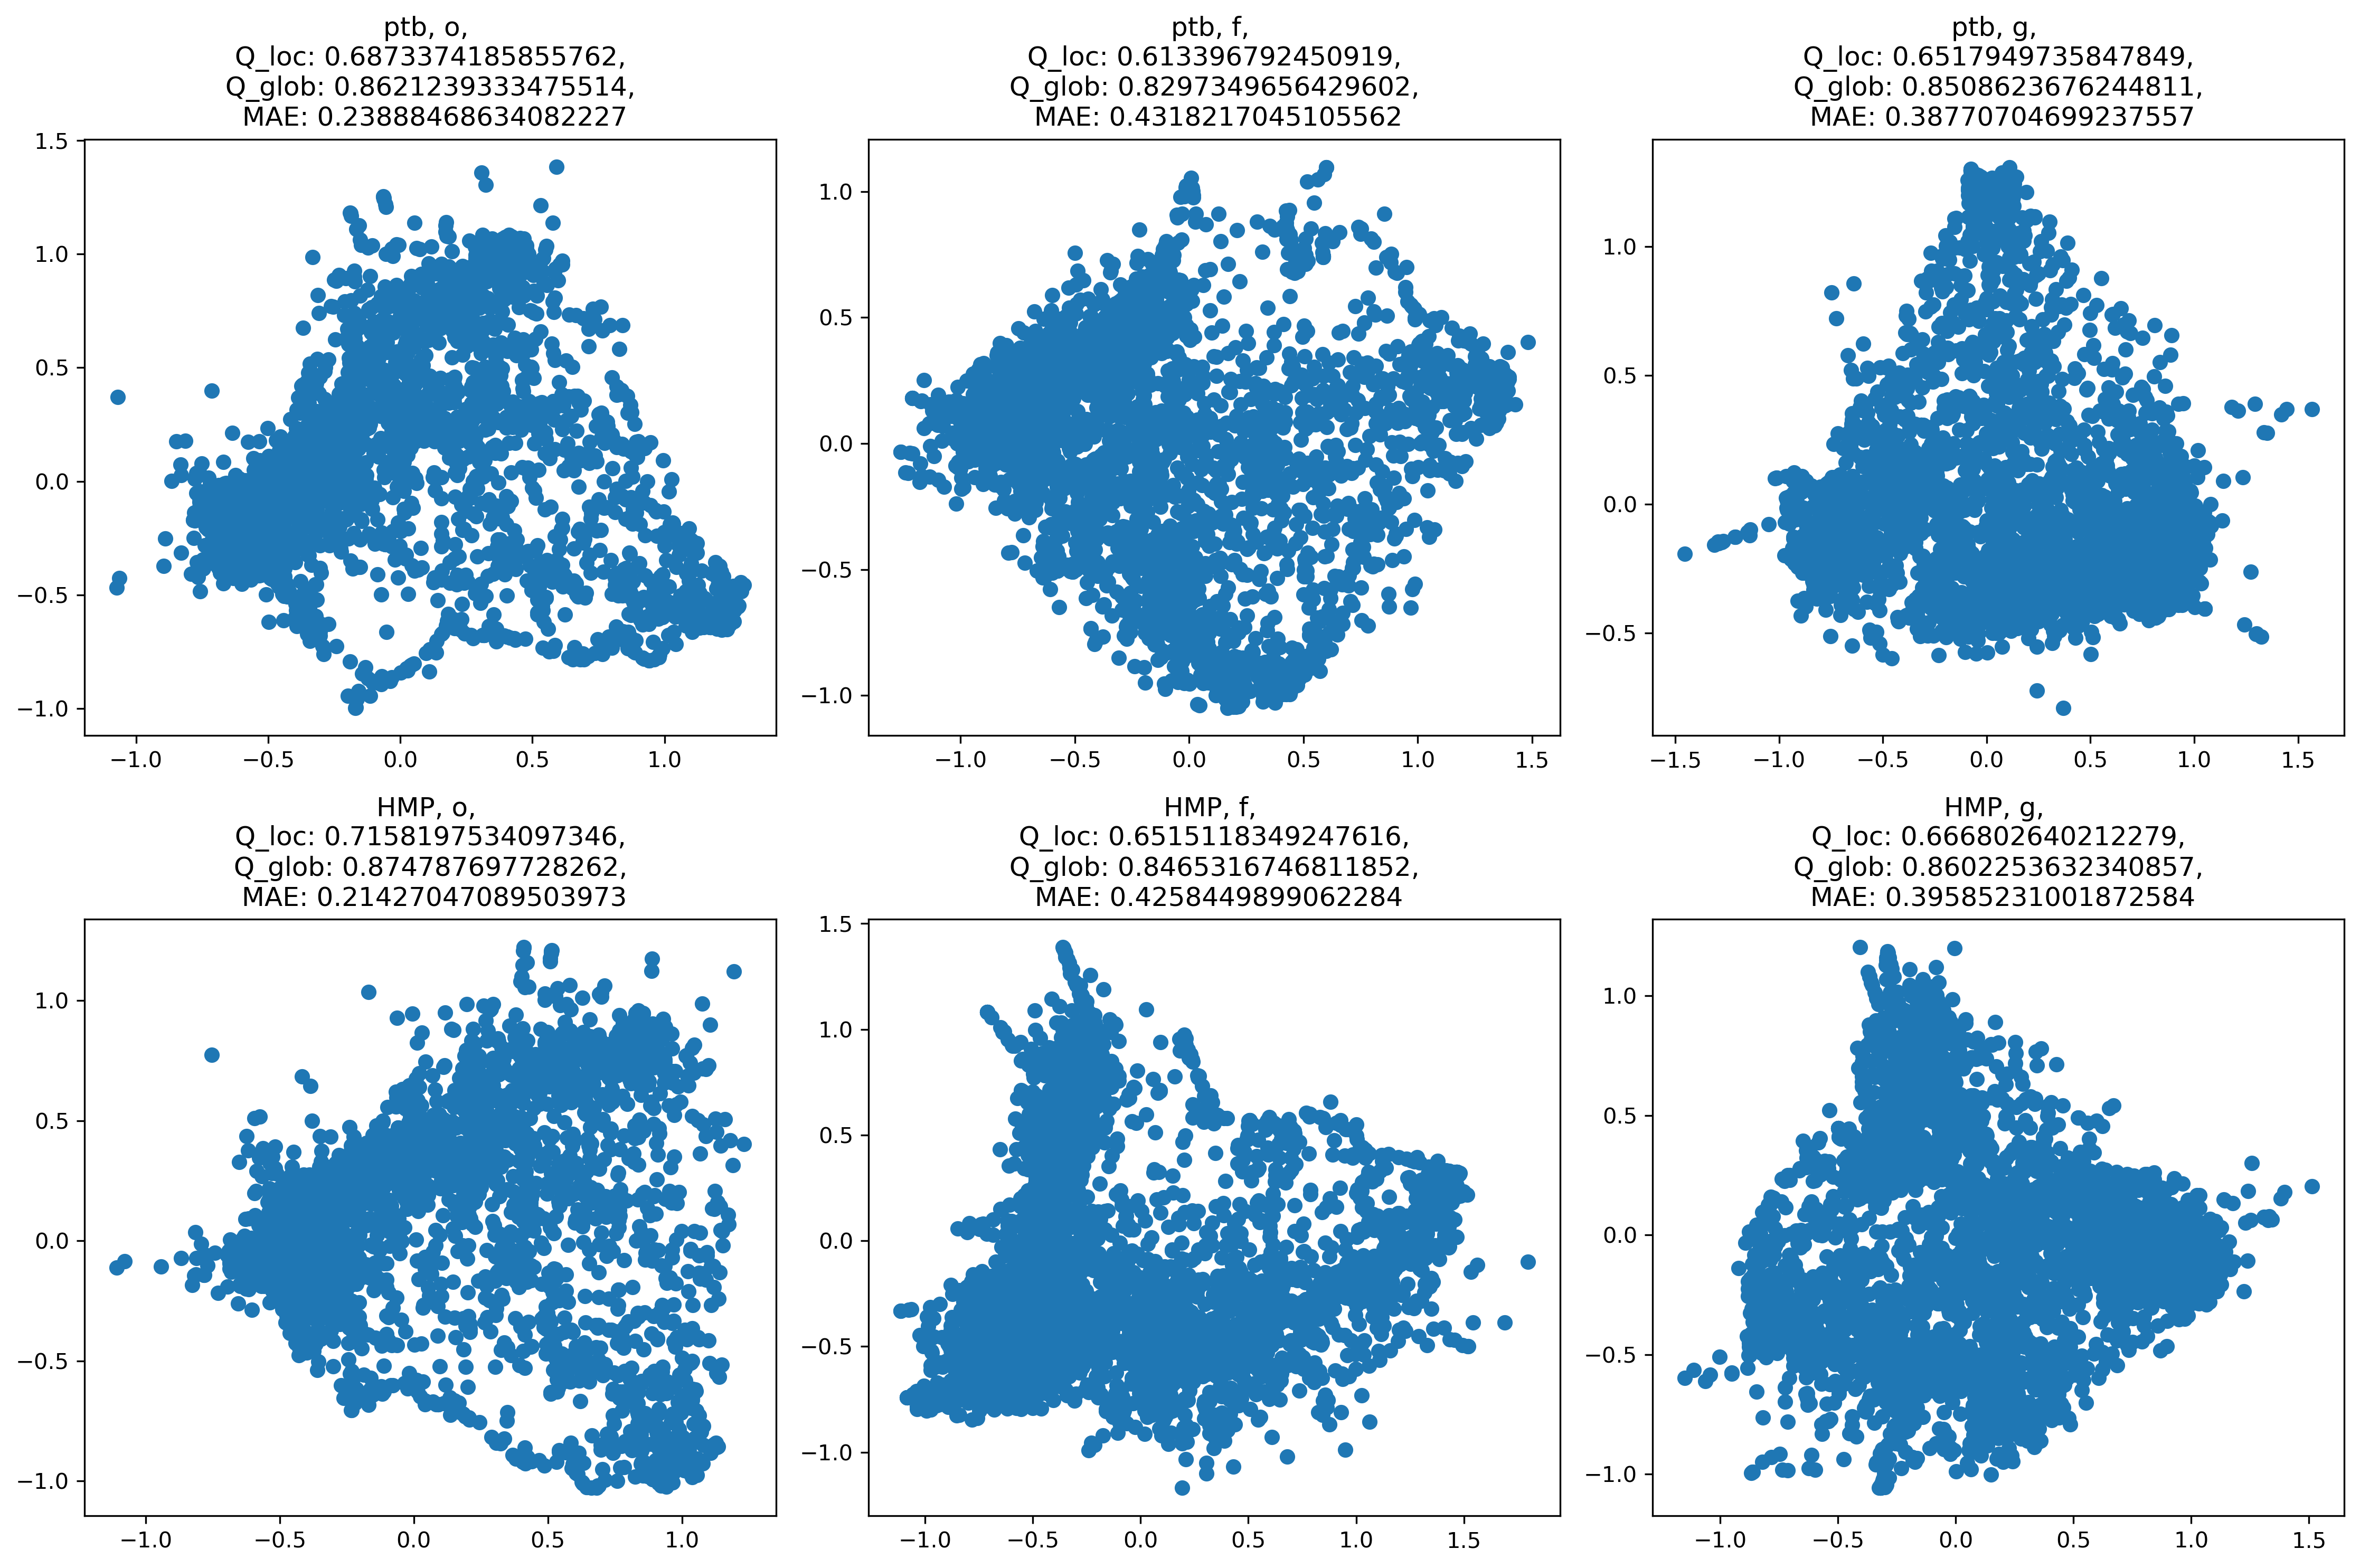

In [164]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,10), dpi=300)
for i,dataset in tqdm_notebook(enumerate(['ptb', 'HMP'])):
    for j,tax_level in enumerate(['o', 'f', 'g']):

        # metric = np.load(f'./distances/orig_BC_{NAME}.npy')

        # lof = LocalOutlierFactor(p=1, n_jobs=-1, metric='precomputed')
        # y = lof.fit_predict(metric)
        # mask = y != -1
        X = data_orig[dataset + '_' + tax_level]#[~mask]


        # Z = UMAP(n_components=10, random_state=42, n_jobs=-1, metric='precomputed').fit_transform(metric)
#         Z = UMAP(n_components=2, random_state=42, n_jobs=-1).fit_transform(X) 
        Z = Isomap(n_components=10, n_jobs=-1).fit_transform(X) 
        
        Q_loc, Q_glob, mae =calculate_Q_mae(X, Z) 
        
        axes[i,j].scatter(Z[:,0], Z[:,1])
        axes[i,j].set_title(f'{dataset}, {tax_level}, \n Q_loc: {Q_loc}, \n Q_glob: {Q_glob}, \n MAE: {mae}')      
        
plt.tight_layout()
plt.show()

In [162]:
c = np.zeros((X.shape[0]))
c[3457:3457 + 1044] = 1
c[3457 + 1044: 3457 + 1044 + 86] = 2

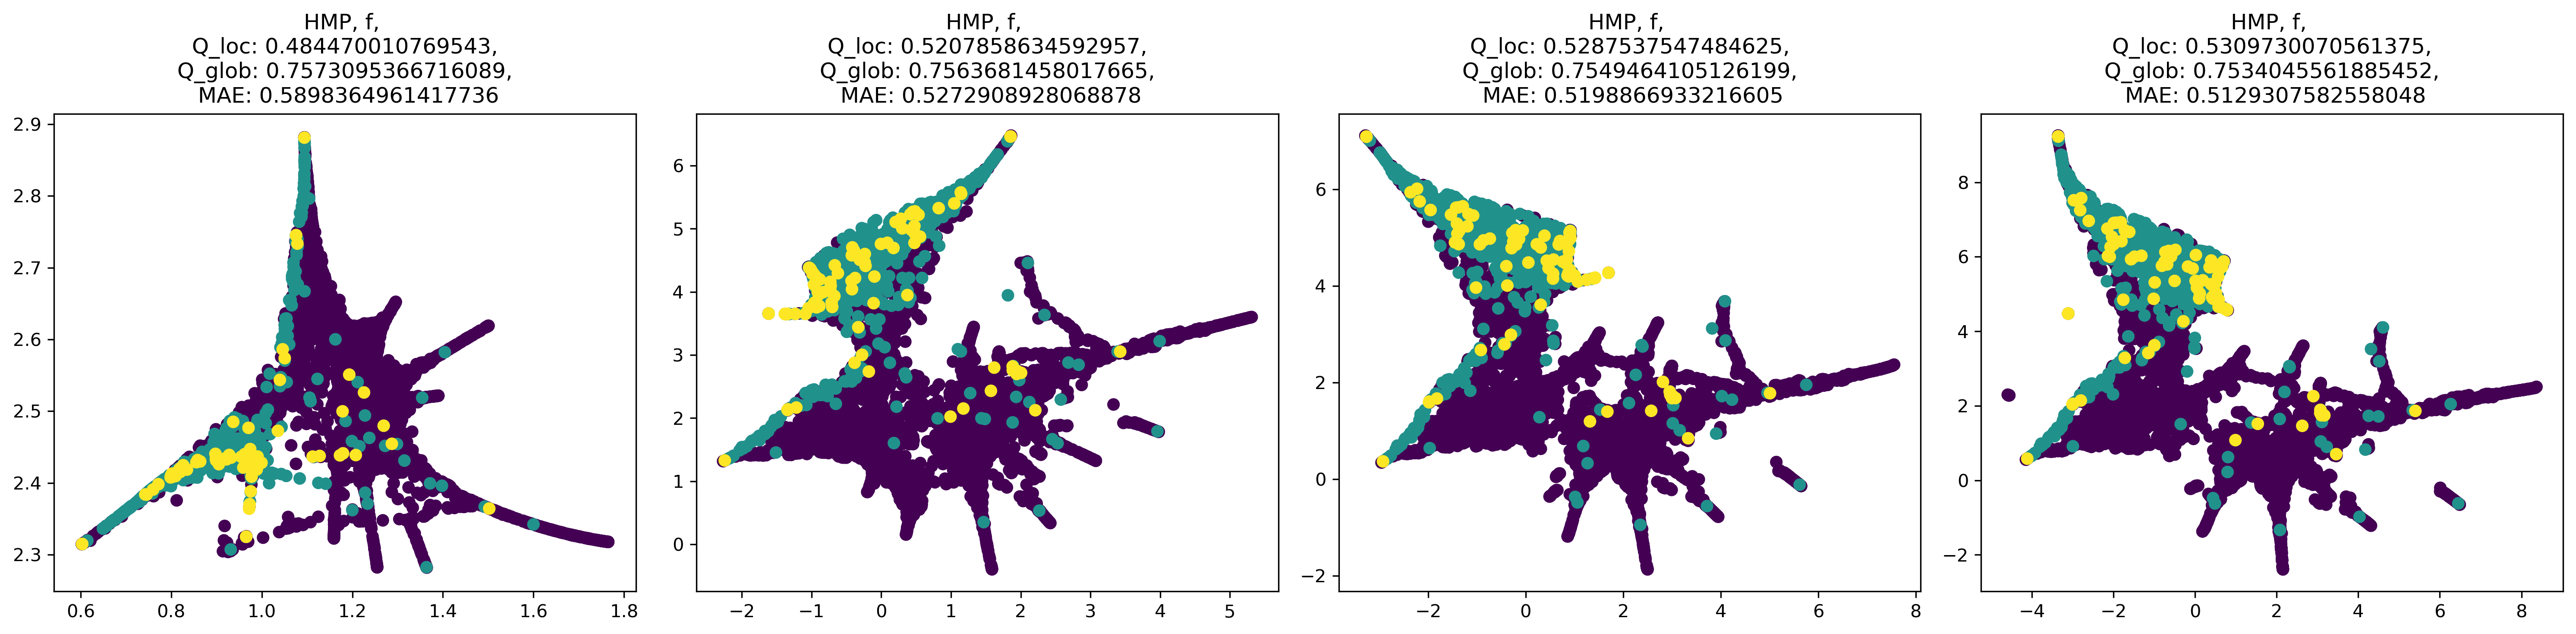

In [163]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,5), dpi=300)
dataset ='HMP'
tax_level = 'f'
for i,r in enumerate(np.linspace(1e-3,.4,num=4)):
    X = data_orig[dataset + '_' + tax_level]#[~mask]
    Z = UMAP(n_components=2, random_state=42, n_jobs=-1, repulsion_strength=r).fit_transform(X) 
    Q_loc, Q_glob, mae =calculate_Q_mae(X, Z) 
    axes[i].scatter(Z[:,0], Z[:,1],c=c)
    axes[i].set_title(f'{dataset}, {tax_level}, \n Q_loc: {Q_loc}, \n Q_glob: {Q_glob}, \n MAE: {mae}')      
        
plt.tight_layout()
plt.show()

In [151]:
# est = KNeighborsRegressor()
# est_mo = MultiOutputRegressor(est)

# scoring_list = []
# kfold = KFold(n_splits=5, shuffle=False)
# for train_index, test_index in tqdm_notebook(kfold.split(X)):
#     X_train = X[train_index]
#     Z_train = Z[train_index]

#     X_test = X[test_index]
#     Z_test = Z[test_index]

#     est_mo.fit(Z_train, X_train)
#     X_pred = est_mo.predict(Z_test)

#     mae = np.linalg.norm(X_pred - X_test, axis=1, ord=1) / (np.linalg.norm(X_test, axis=1, ord=1) + 1e-7)
#     scoring_list.append(mae)
    
# scoring_list = np.concatenate(scoring_list)

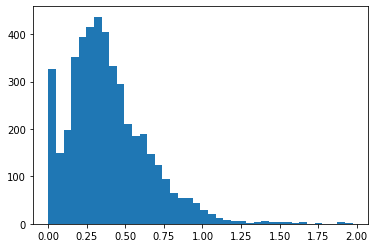

0.3895502597320091


In [145]:
plt.hist(scoring_list, bins=40)
plt.show()
print(scoring_list.mean())

In [139]:
# thr=.8
# mask = scoring_list > thr
# print(sum(mask)/len(mask))

In [42]:
# thr = 1 
# mask = scoring_list > thr
# plt.scatter(Z[:,0][mask], Z[:,1][mask], c='red', alpha=0.5)
# plt.scatter(Z[:,0][~mask], Z[:,1][~mask], c='blue', alpha=0.01)
# plt.show()

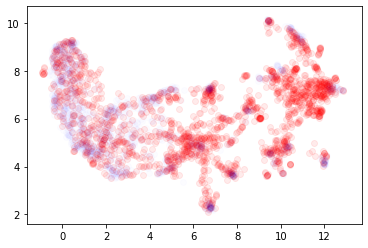

In [7]:
# for y_k in np.unique(y): 
#     mask = y==y_k
#     if y_k == 0 or y_k==1:
#         alpha = 0.01
#         color='blue'
#     elif y_k == -1:
#         alpha = 0.08
#         color = 'red'
#     plt.scatter(ump[:,0][mask], ump[:,1][mask], c=color, alpha=alpha)
# plt.show()

# Isoforest iterative

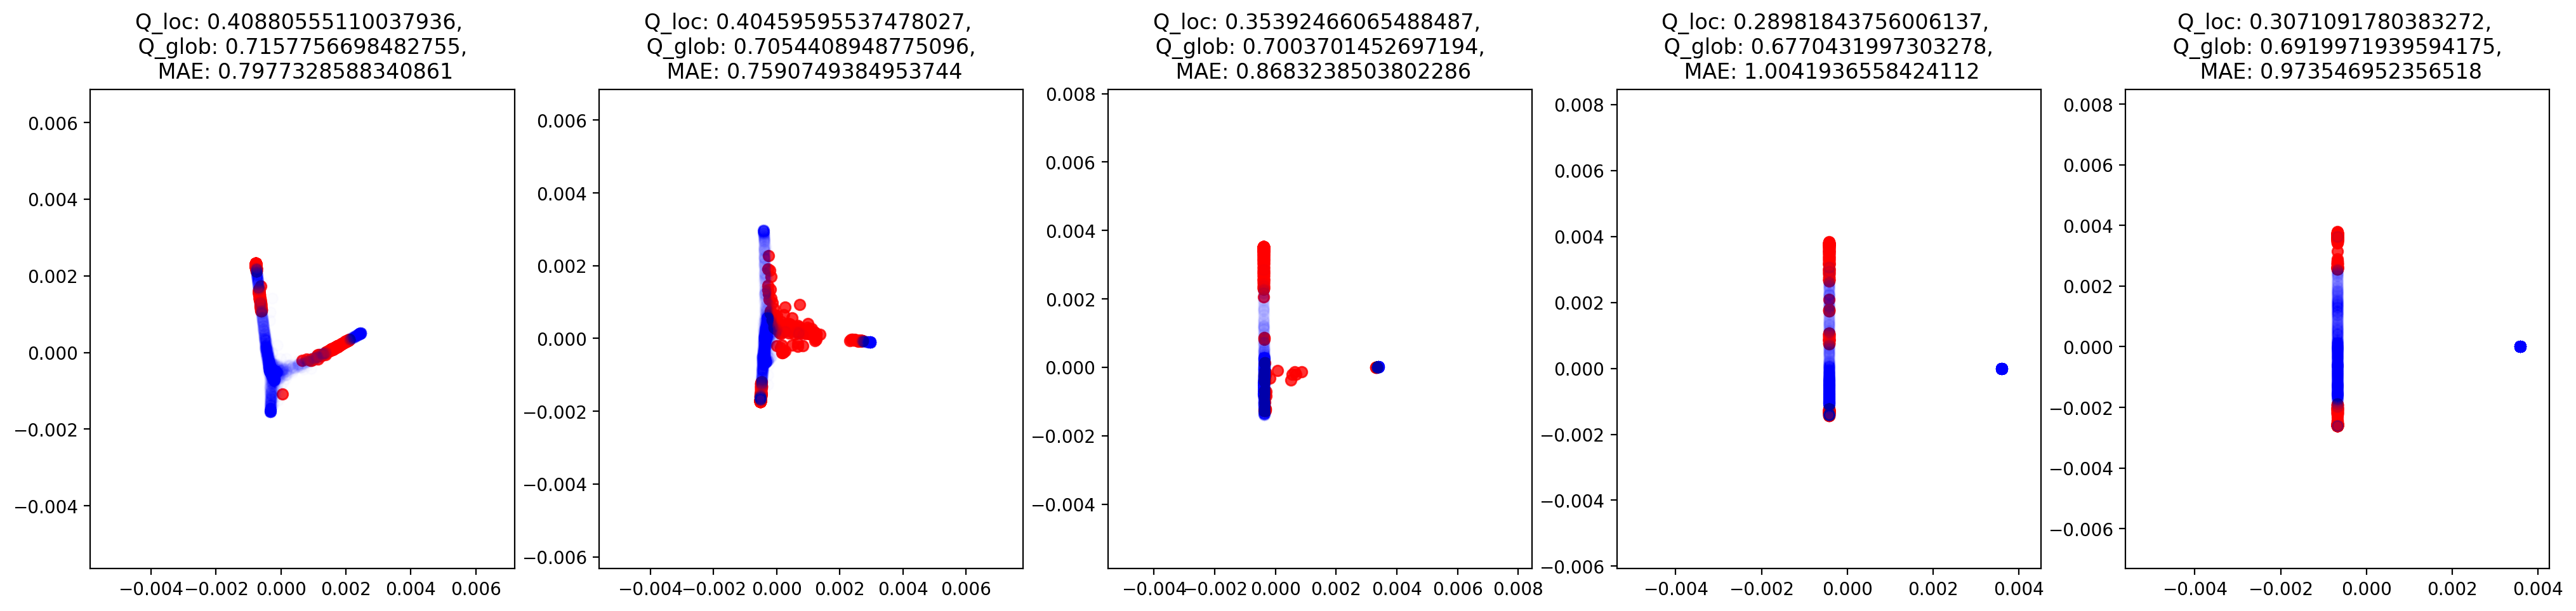

In [17]:
method = IsolationForest(n_jobs=-1, random_state=33, max_features=0.8, contamination=0.1, bootstrap=0.9)
dataframe = data_orig[NAME]
n_iter = 5

fig,axes = plt.subplots(ncols=n_iter, nrows=1, figsize=(n_iter*5,5), dpi=200)
X = dataframe
N = X.shape[0]
y_ = np.arange(N)

for i in range(n_iter):
    ump =  UMAP(n_components=2, random_state=42, n_jobs=-1).fit_transform(X) #UMAP(n_components=2, random_state=42, n_jobs=-1).fit_transform(X)
    Q_loc, Q_glob, mae = calculate_Q_mae(X, ump)

    y = method.fit_predict(ump)
    #plot
    for y_k in np.unique(y): 
        mask = y==y_k
        if y_k == 0 or y_k==1:
            alpha = 0.01
            color='blue'
        elif y_k == -1:
            alpha = 0.8
            color = 'red'
        axes[i].scatter(ump[:,0][mask], ump[:,1][mask], c=color, alpha=alpha)
    axes[i].set_title(f'Q_loc: {Q_loc}, \n Q_glob: {Q_glob}, \n MAE: {mae}')
    y_ = y_[y!=-1]
    X = dataframe[y_]
    
plt.show()